In [34]:
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from cvxopt import matrix, solvers
from sklearn.datasets import load_iris
C = 100

In [35]:
def poly_kernel(x, z, degree, intercept):
    return np.power(np.matmul(x, z.T) + intercept, degree)


def gaussian_kernel(x, z, sigma):
    n = x.shape[0]
    m = z.shape[0]
    xx = np.dot(np.sum(np.power(x, 2), 1).reshape(n, 1), np.ones((1, m)))
    zz = np.dot(np.sum(np.power(z, 2), 1).reshape(m, 1), np.ones((1, n)))
    return np.exp(-(xx + zz.T - 2 * np.dot(x, z.T)) / (2 * sigma ** 2))


def linear_kernel(x, z):
    return np.matmul(x, z.T)

def get_iris():
    iris = load_iris()
    iris_df = pd.DataFrame(data=np.c_[iris["data"], iris["target"]], columns=iris["feature_names"] + ["target"])
    # Retain only 2 linearly separable classes
    iris_df = iris_df[iris_df["target"].isin([0, 1])]
    iris_df["target"] = iris_df[["target"]].replace(0, -1)
    # Select only 2 attributes
    iris_df = iris_df[["petal length (cm)", "petal width (cm)", "target"]]
    iris_df.head()

    X = iris_df[["petal length (cm)", "petal width (cm)"]].to_numpy()
    y = iris_df[["target"]].to_numpy()
    return X, y


def get_data(filename):
    df = pd.read_csv(filename)
    df = df.head(100)
    df.color = df.color.replace(0, -1)
    X = df[['x', 'y']].to_numpy()  # iris_df[["petal length (cm)", "petal width (cm)"]].to_numpy()
    y = df['color'].to_numpy().reshape((-1, 1))  # iris_df[["target"]].to_numpy()
    return X, y

In [36]:
X, y = get_data('linearly-separable-data.csv')

x_min = X[:, 0].min()-0.1
x_max = X[:, 0].max()+0.1
y_min = X[:, 1].min()-0.1
y_max = X[:, 1].max()+0.1

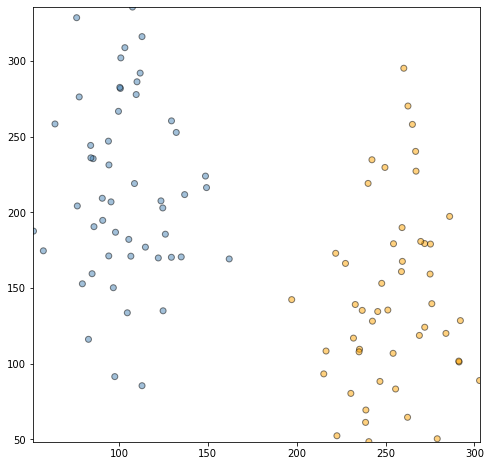

In [37]:
plt.figure(figsize=(8, 8))
colors = ["steelblue", "orange"]
plt.scatter(X[:, 0], X[:, 1], c=y.ravel(), alpha=0.5, cmap=matplotlib.colors.ListedColormap(colors), edgecolors="black")
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.show()

In [38]:
n = X.shape[0]
H = np.dot(y * X, (y * X).T)
q = np.repeat([-1.0], n)[..., None]

A = y.reshape(1, -1).astype(float)
b = 0.0

if C is None or C == 0:
    G = np.negative(np.eye(n))
    h = np.zeros(n)
else:
    G = matrix(np.vstack((np.eye(n) * -1, np.eye(n))))
    h = matrix(np.hstack((np.zeros(n), np.ones(n) * C)))

P = matrix(H)
q = matrix(q)
G = matrix(G)
h = matrix(h)
A = matrix(A)
b = matrix(b)

In [39]:
sol = solvers.qp(P, q, G, h, A, b, kktsolver='ldl', options={'kktreg':1e-9})
alphas = np.array(sol["x"])

     pcost       dcost       gap    pres   dres
 0: -4.0403e+02 -3.2684e+05  8e+05  4e-01  1e-08
 1: -9.8943e+01 -3.3673e+04  6e+04  3e-02  1e-08
 2: -6.1039e-01 -1.8810e+03  3e+03  1e-03  5e-09
 3:  1.5384e+00 -2.0435e+01  3e+01  1e-05  1e-10
 4:  7.4512e-01 -9.5538e-01  2e+00  1e-07  2e-12
 5:  1.0967e-01 -1.2729e-01  2e-01  1e-07  2e-13
 6:  1.4737e-02 -1.9404e-02  3e-02  4e-08  6e-14
 7:  1.6666e-03 -3.1786e-03  5e-03  2e-08  3e-14
 8:  3.2343e-04 -1.4259e-03  2e-03  9e-09  2e-14
 9: -4.6679e-04 -2.0415e-03  2e-03  5e-09  1e-13
10: -8.6922e-04 -1.3476e-03  5e-04  3e-09  5e-14
11: -1.0531e-03 -1.1475e-03  9e-05  6e-10  2e-14
12: -1.0942e-03 -1.0952e-03  1e-06  1e-09  2e-14
13: -1.0946e-03 -1.0947e-03  1e-08  1e-09  2e-14
Optimal solution found.


In [40]:
w = np.dot((y * alphas).T, X)[0]
S = (alphas > 1e-5).flatten()
b = np.mean(y[S] - np.dot(X[S], w.reshape(-1, 1)))

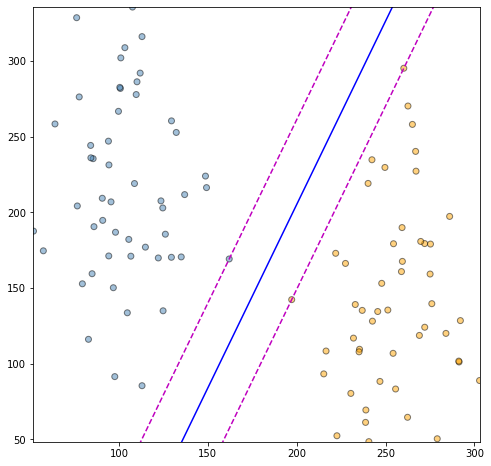

In [41]:
xx = np.linspace(x_min, x_max)
a = -w[0] / w[1]
yy = a * xx - (b) / w[1]
margin = 1 / np.sqrt(np.sum(w ** 2))
yy_neg = yy - np.sqrt(1 + a ** 2) * margin
yy_pos = yy + np.sqrt(1 + a ** 2) * margin
plt.figure(figsize=(8, 8))
plt.plot(xx, yy, "b-")
plt.plot(xx, yy_neg, "m--")
plt.plot(xx, yy_pos, "m--")
colors = ["steelblue", "orange"]
plt.scatter(X[:, 0], X[:, 1], c=y.ravel(), alpha=0.5, cmap=matplotlib.colors.ListedColormap(colors), edgecolors="black")
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.show()

In [42]:
y_preds = np.zeros_like(y)
for i in range(len(y_preds)):
    y_preds[i] = np.sign(np.dot(w, X[i]) + b)
print("my W:", w)
print("my b:", b)
print(f"my score: {(y_preds == y).mean()}")

my W: [ 0.04325758 -0.01783467]
my b: -4.989998363491368
my score: 1.0


In [43]:
from sklearn import svm

clf = svm.SVC(kernel="linear", C=C)
clf.fit(X, y.ravel())
w = clf.coef_[0]
b = clf.intercept_
print("built-in W:", w)
print("built-in b:", b)
print(f"built-in score: {clf.score(X, y)}")


built-in W: [ 0.04325741 -0.01783459]
built-in b: [-4.9899793]
built-in score: 1.0


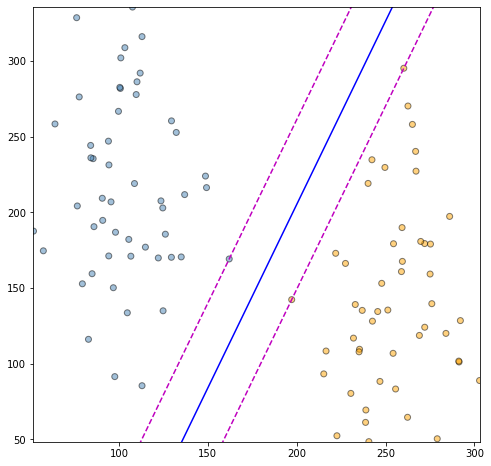

In [44]:
xx = np.linspace(x_min, x_max)
a = -w[0] / w[1]
yy = a * xx - (b) / w[1]
margin = 1 / np.sqrt(np.sum(w ** 2))
yy_neg = yy - np.sqrt(1 + a ** 2) * margin
yy_pos = yy + np.sqrt(1 + a ** 2) * margin
plt.figure(figsize=(8, 8))
plt.plot(xx, yy, "b-")
plt.plot(xx, yy_neg, "m--")
plt.plot(xx, yy_pos, "m--")
colors = ["steelblue", "orange"]
plt.scatter(X[:, 0], X[:, 1], c=y.ravel(), alpha=0.5, cmap=matplotlib.colors.ListedColormap(colors), edgecolors="black")
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.show()